In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
import os
import glob
import itertools
import pandas as pd

from bn3d.analysis import get_results_df, get_thresholds_df
from bn3d.plots._threshold import detailed_plot, update_plot, plot_crossing_collapse, plot_combined_threshold_vs_bias, xyz_sector_plot
from bn3d.plots._hashing_bound import get_hashing_bound

# Load results

In [3]:
dir_path = os.getcwd()

# experiments = ["det_rhombic_bposd_xzzx_xbias", "det_rhombic_bposd_undef_xbias", "det_unrot_bposd_xzzx_zbias", "det_unrot_bposd_undef_zbias"]
# experiments = ["det_unrot_bposd_xzzx_zbias", "det_rot_bposd_undef_zbias"]
experiments = ['det_xcube_bposd_undef_zbias', 'det_xcube_bposd_xzzx_zbias']
author = 'arthur'

input_dir, output_dir, list_jobs = {}, {}, {}
for exp_name in experiments:
    input_dir[exp_name] = os.path.join(dir_path, f"../results/{author}/threshold/{exp_name}/inputs")
    output_dir[exp_name] = os.path.join(dir_path, f"../results/{author}/threshold/{exp_name}/results")
    list_jobs[exp_name] = list(map(lambda x: os.path.basename(x).split('.json')[0], os.listdir(input_dir[exp_name])))

In [4]:
results = {exp_name: get_results_df(list_jobs[exp_name], output_dir[exp_name], input_dir[exp_name]) for exp_name in experiments}

for exp_name in experiments:
    # Sort by probability
    results[exp_name].sort_values("probability", inplace=True)

## Remove some sizes

In [17]:
for exp_name in experiments:
    results[exp_name].drop(results[exp_name][results[exp_name]['size'] == (9,9,9)].index, inplace=True)

# Analyze results

### Limit probability range manually

In [18]:
exp_name = "det_rhombic_bposd_undef_xbias"
proba_range = {'Pauli X0.9524Y0.0238Z0.0238': [0, 0.26]}

if exp_name in results.keys():
    for error_model, (lower, upper) in proba_range.items():
        results[exp_name].drop(results[exp_name][(results[exp_name]['error_model'] == error_model) &
                               ((results[exp_name]['probability'] > upper) |
                               (results[exp_name]['probability'] < lower))].index,
                               inplace=True)

### Get thresholds

In [19]:
thresholds_df, trunc_results_df, params_bs_list = {}, {}, {}

for exp_name in experiments:
    thresholds_df[exp_name], trunc_results_df[exp_name], params_bs_list[exp_name] = get_thresholds_df(results[exp_name], 
                                                                                                      ftol_est=1e-3, 
                                                                                                      ftol_std=1e-3, 
                                                                                                      maxfev=10000)

## Sector plots

Error models ['Pauli X0.3333Y0.3333Z0.3333' 'Pauli X0.1250Y0.1250Z0.7500'
 'Pauli X0.0455Y0.0455Z0.9091' 'Pauli X0.0161Y0.0161Z0.9677'
 'Pauli X0.0050Y0.0050Z0.9901' 'Pauli X0.0000Y0.0000Z1.0000']


/home/artix41/miniconda3/envs/qec-dan/lib/python3.8/site-packages/bn3d/plots/_threshold.py:94: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)


<Figure size 432x288 with 0 Axes>

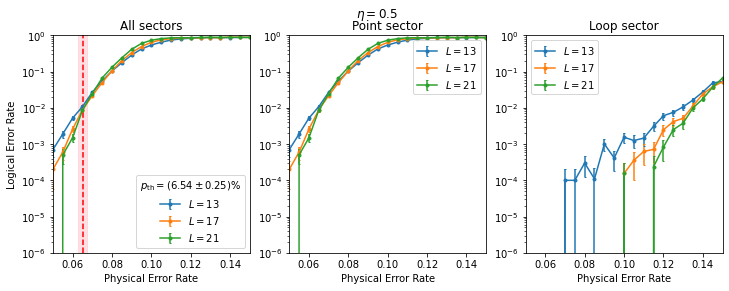

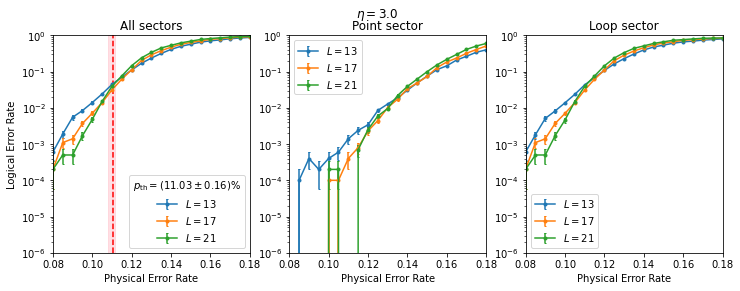

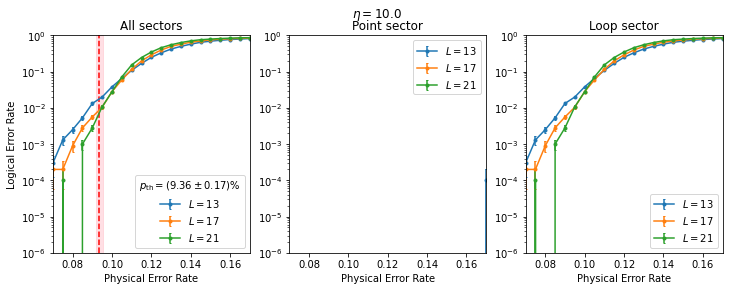

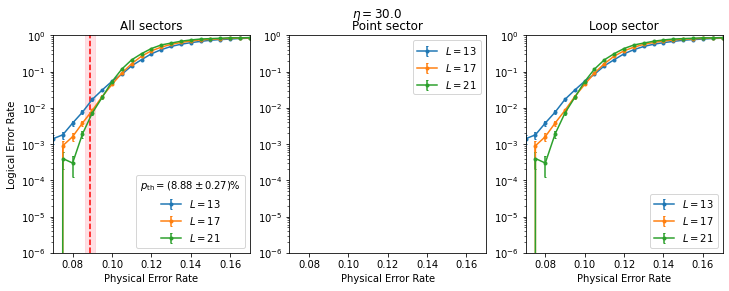

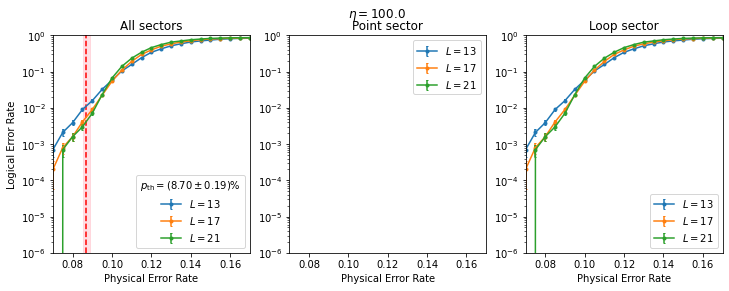

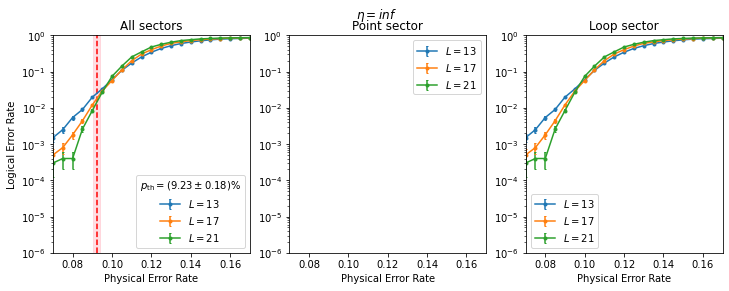

In [36]:
exp_index = 0
eta_key = 'eta_z'
yscale = 'log'
save = True

exp_name = experiments[exp_index]
title = exp_name.replace("_", "-")

if not os.path.exists(f"../results/{author}/images/{title}/"):
    os.makedirs(f"../results/{author}/images/{title}/")
    
error_models = np.sort(np.unique(results[exp_name]["error_model"]))
if eta_key == 'eta_z':
    error_models = np.flip(error_models)
print("Error models", error_models)
    
for i in range(len(error_models)):
    error_model = error_models[i]
    curr_results = results[exp_name][(results[exp_name]['error_model'] == error_model)]
    
    xlim = (np.min(curr_results["probability"]), np.max(curr_results["probability"]))
#     xlim = (0., 0.5)
                    
    detailed_plot(plt, curr_results, error_model, thresholds_df=thresholds_df[exp_name], x_limits=[xlim, xlim, xlim],
                  yscale=yscale, eta_key=eta_key, min_y_axis=1e-6)
    
#     detailed_plot(plt, curr_results, error_model, x_limits=[xlim, xlim, xlim],
#                   yscale=yscale, eta_key=eta_key, min_y_axis=1e-6)

# Saving
if save:
    with PdfPages(f"../results/{author}/images/{title}/sectors-{title}-{yscale}.pdf") as pdf:
        for fig in range(1, plt.figure().number):
            pdf.savefig(fig)

## XYZ sectors plot

Error models ['Deformed XZZX Pauli X0.0000Y0.0000Z1.0000'
 'Deformed XZZX Pauli X0.0050Y0.0050Z0.9901'
 'Deformed XZZX Pauli X0.0161Y0.0161Z0.9677'
 'Deformed XZZX Pauli X0.0455Y0.0455Z0.9091'
 'Deformed XZZX Pauli X0.1250Y0.1250Z0.7500'
 'Deformed XZZX Pauli X0.3333Y0.3333Z0.3333']


/home/artix41/miniconda3/envs/qec-dan/lib/python3.8/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


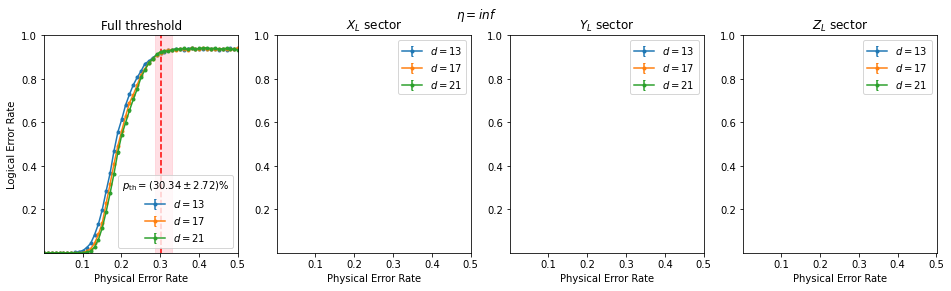

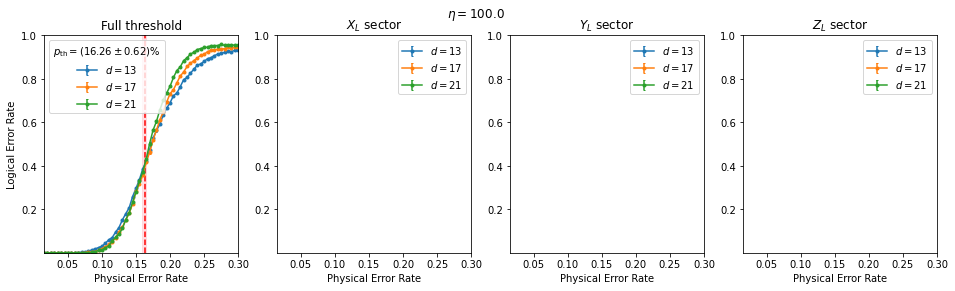

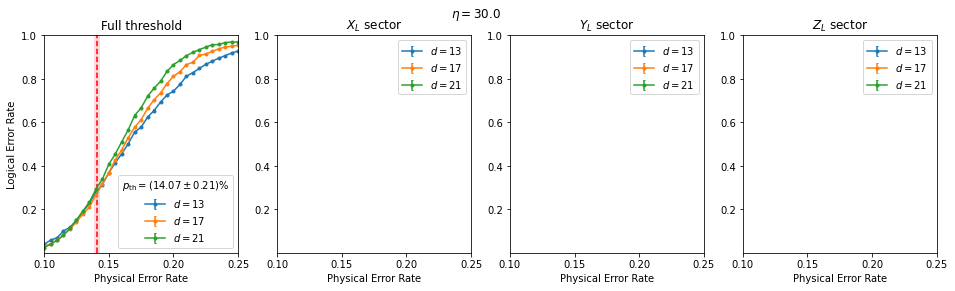

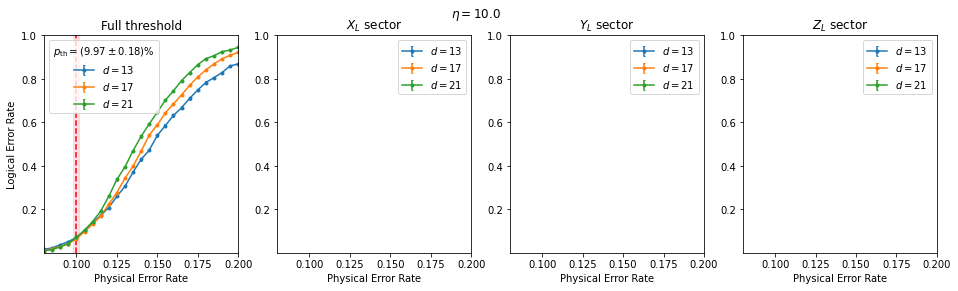

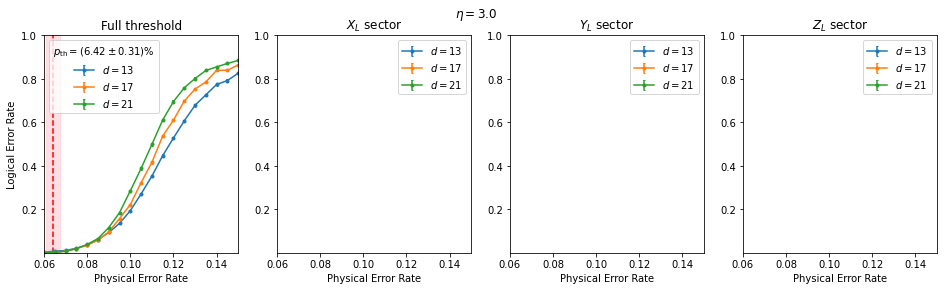

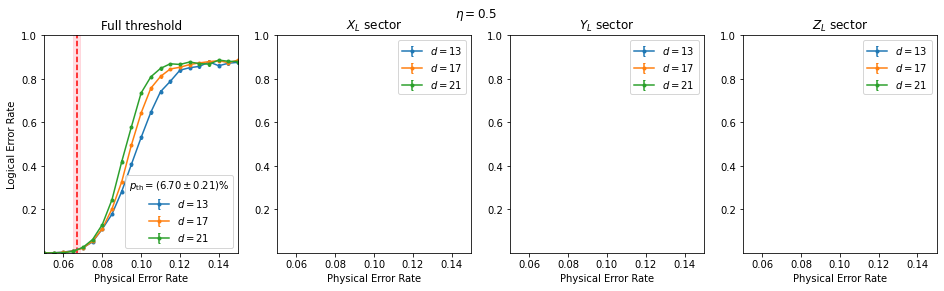

In [28]:
exp_index = 1
eta_key = 'eta_z'
yscale = 'linear'
save = False

exp_name = experiments[exp_index]
title = exp_name.replace("_", "-")
 
if 'rot' or 'lay' in title:
    if not os.path.exists(f"../results/eric/images/{title}/"):
        os.makedirs(f"../results/eric/images/{title}/")

    error_models = np.unique(results[exp_name]['error_model'])
    print("Error models", error_models)

    for i in range(len(error_models)):
        error_model = error_models[i]
        curr_results = results[exp_name][(results[exp_name]['error_model'] == error_model)]

        xlim = (np.min(curr_results["probability"]), np.max(curr_results["probability"]))
    #     xlim = (0, 0.5)

        xyz_sector_plot(plt, curr_results, error_model, thresholds_df=thresholds_df[exp_name], 
                        x_limits=[xlim, xlim, xlim, xlim], eta_key=eta_key,
                        yscale=yscale)

    # Saving
    if save:
        with PdfPages(f"../results/eric/images/{title}/xyz-sectors-{title}-{yscale}.pdf") as pdf:
            for fig in range(1, plt.figure().number):
                pdf.savefig(fig)

## Unique plot

In [ ]:
exp_index = 0
eta_key = 'eta_z'
yscale = 'linear'
save = True

exp_name = experiments[exp_index]
title = exp_name.replace("_", "-")
 
if 'rot' or 'lay' in title:
    if not os.path.exists(f"../results/eric/images/{title}/"):
        os.makedirs(f"../results/eric/images/{title}/")

    error_models = np.unique(results[exp_name]['error_model'])
    print("Error models", error_models)

    for i in range(len(error_models)):
        error_model = error_models[i]
        curr_results = results[exp_name][(results[exp_name]['error_model'] == error_model)]

        xlim = (np.min(curr_results["probability"]), np.max(curr_results["probability"]))
        xlim = (0., 0.5)
        ylim = (0., 0.55)

        update_plot(plt, curr_results, error_model,
                    xlim=xlim, ylim=ylim, eta_key=eta_key,
                    yscale=yscale)

    # Saving
    if save:
        with PdfPages(f"../results/eric/images/{title}/simple-{title}-{yscale}.pdf") as pdf:
            for fig in range(1, plt.figure().number):
                pdf.savefig(fig)

## Plot threshold vs bias

### Add infinite bias row for deformed models with 50% threshold

In [30]:
row_inf_bias = {'error_model': 'Deformed XZZX Pauli X0.0000Y0.0000Z1.0000',
                'noise_direction': (0, 0, 1),
                'r_x': 0, 'r_y': 0, 'r_z': 1,
                'h': 0., 'v': 0.,
                'eta_x': 0, 'eta_y': 0, 'eta_z': np.inf,
                'p_th_sd': 0.,
                'p_th_nearest': 0.5,
                'p_left': 0.5,
                'p_right': 0.5,
                'p_th_fss': 0.5,
                'p_th_fss_left': 0.5,
                'p_th_fss_right': 0.5,
                'p_th_fss_se': 0.,
                'fss_params': (0.5,0,0,0,0)}
# thresholds_df['det_rot_bposd_xzzx_zbias'] = thresholds_df['det_rot_bposd_xzzx_zbias'].append(row_inf_bias, ignore_index=True)
# thresholds_df['det_unrot_bposd_xzzx_zbias'] = thresholds_df['det_unrot_bposd_xzzx_zbias'].append(row_inf_bias, ignore_index=True)
thresholds_df['det_xcube_bposd_xzzx_zbias'].drop(thresholds_df['det_xcube_bposd_xzzx_zbias'][np.isclose(thresholds_df['det_xcube_bposd_xzzx_zbias']['r_z'], 1)].index, inplace=True)
thresholds_df['det_xcube_bposd_xzzx_zbias'] = thresholds_df['det_xcube_bposd_xzzx_zbias'].append(row_inf_bias, ignore_index=True)

### Remove unwanted bias ratios

In [ ]:
# Bias 1000
thresholds_df['det_unrot_bposd_xzzx_zbias'].drop(thresholds_df['det_unrot_bposd_xzzx_zbias'][np.isclose(thresholds_df['det_unrot_bposd_xzzx_zbias']['eta_z'], 1000)].index, inplace=True)

### Get data from XZZX paper

In [ ]:
csv_file_xzzx = "../data/xzzx/xzzx_data.csv"
csv_file_css = "../data/xzzx/css_data.csv"

xzzx_data = pd.read_csv(csv_file_xzzx)
css_data = pd.read_csv(csv_file_css)

In [13]:
xzzx_data.iloc[-1, xzzx_data.columns.get_loc('bias')] = np.inf
css_data.iloc[-1, css_data.columns.get_loc('bias')] = np.inf

In [14]:
thresholds_df['2d_xzzx'] = pd.DataFrame({'eta_z': xzzx_data['bias'], 
                                         'p_th_fss': xzzx_data['threshold'],
                                         'p_th_fss_left': xzzx_data['threshold'] - xzzx_data['threshold_error'],
                                         'p_th_fss_right': xzzx_data['threshold'] + xzzx_data['threshold_error']})

# thresholds_df['2d_css'] = pd.DataFrame({'eta_z': css_data['bias'], 
#                                          'p_th_fss': css_data['threshold'],
#                                          'p_th_fss_left': css_data['threshold'] - css_data['threshold_error'],
#                                          'p_th_fss_right': css_data['threshold'] + css_data['threshold_error']})

### Plot Cubic-Rhombic

In [25]:
cmap = plt.cm.get_cmap('tab10')
thresholds_df_list = [thresholds_df['det_unrot_bposd_xzzx_zbias'], 
                      thresholds_df['det_unrot_bposd_undef_zbias'], 
                      thresholds_df['det_rhombic_bposd_xzzx_xbias'], 
                      thresholds_df['det_rhombic_bposd_undef_xbias']]
plot_combined_threshold_vs_bias(plt, Line2D, thresholds_df_list,
                                hashing=True,
                                eta_keys=['eta_z', 'eta_z', 'eta_x', 'eta_x', 'eta_z'], 
                                labels=['XZ4X', 'Cubic CSS', 'Rhombic deformed', 'Rhombic CSS'],
                                colors=[cmap(3), cmap(3), cmap(0), cmap(0), cmap(1)],
                                alphas=[1, 1, 1, 1, 1],
                                markers=['v', 's', 'o', 'x', '^'],
                                linestyles=['-', '--', '-', '--', '-'],
                                depolarizing_labels=[True, False, True, False, True])

KeyError: 'det_unrot_bposd_xzzx_zbias'

### Plot X-Cube

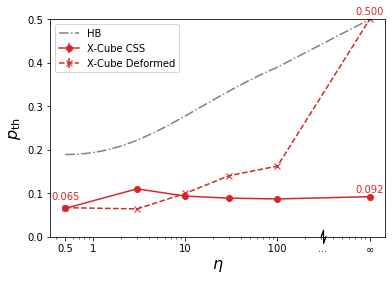

In [42]:
cmap = plt.cm.get_cmap('tab10')
thresholds_df_list = [thresholds_df['det_xcube_bposd_undef_zbias'], 
                      thresholds_df['det_xcube_bposd_xzzx_zbias']]
plot_combined_threshold_vs_bias(plt, Line2D, thresholds_df_list,
                                hashing=True,
                                eta_keys=['eta_z', 'eta_z'], 
                                labels=['X-Cube CSS', 'X-Cube Deformed'],
                                colors=[cmap(3), cmap(3)],
                                alphas=[1, 1],
                                markers=['o', 'x'],
                                linestyles=['-', '--'],
                                depolarizing_labels=[True, False])
plt.savefig('xcube_threshold_vs_bias.pdf')